# BikeSales Modelling

In [230]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')



In [231]:
#Load the data and infer the date format for the date features

df = pd.read_csv('clean_sport2.csv', 
                  parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                  infer_datetime_format=True)
df.head()
sport = df

In [232]:
# sport.drop(['Body','Drive_Type','Fuel_Type','Gear_Change_Method','Gear_Type',
#             'Network_ID','Registration_Plate','URL','Windscreen'], axis=1, inplace=True)

# SELECT INDIVIDUAL FEATURES - we want to simplify the model

In [233]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [234]:
def add_dummy_variables(df, categorical_features):
    
    additional = pd.get_dummies(df[categorical_features])
    df[additional.columns] = additional
    return df.drop(categorical_features, axis=1)

def feature_plot(model,X,top=10):
    
    feats_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['FeatureImportance'])
    feats_imp = feats_imp.sort_values('FeatureImportance', ascending=False)[:top]

    feats_imp.plot(kind='barh', figsize=(12,6), legend=False)
    plt.title('Feature Importance from XgBoost Classifier')
    sns.despine(left=True, bottom=True)
    plt.gca().invert_yaxis()
    
def plot_accuracy_predictions(y_test, pred):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test,pred)
    ax.plot([y_test(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
    ax.set_xlabel('Measured');
    ax.set_ylabel('Predicted');
    ax.set_title('Accuracy of Predictions');
    

In [235]:
print (sport.shape)
sport_numbers = sport.select_dtypes(include='number')
print (sport_numbers.shape)



(2177, 76)
(2177, 32)


In [236]:
sport.head()

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Starter,State,Suburb,Swingarm_Type,Traction_Control,Warranty_KMs,Wheel_Type,Seller,Brand,Model
0,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,QLD,Ashgrove,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
1,62.0,2.0,11.0,2.0,129.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,WA,South perth,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r special edition
2,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,QLD,Arana hills,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
3,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,WA,none,Dual Sided,No,No,Spoke,Dealer,Kawasaki,Ninja 250r ex250j
4,48.6,4.0,10.0,4.0,129.0,250.0,296.0,118.0,3.459387,13.0,...,Electric,WA,none,Dual Sided,No,No,Spoke,Dealer,Honda,Cbr250r


In [237]:
numerical_features = list(df.select_dtypes(include='number').columns)
categorical_features = list(df.select_dtypes(exclude='number').columns)

# categorical_features = ['Bike', 'Body', 'Colour', 'Cooling', 'Country_of_Origin', 
#                         'Engine_Config', 'Fuel_Type', 'State', 'Suburb', 'Seller', 
#                         'Brand', 'Model'] 

#categorical_features = ['Bike', 'Body', 'Brand', 'Model', 'Seller']

In [238]:
sport = add_dummy_variables(sport, categorical_features)

In [239]:
sport.head()

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Model_f4 1000 abs,Model_f4 1000s corse,Model_f4 312 r 1000,Model_f4 312 r 1000 11,Model_f4 750 s,Model_f4 750 s f4s 11,Model_f4 r,Model_f4 rr,Model_f4 rr 1000,Model_f4ago 1000
0,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
1,62.0,2.0,11.0,2.0,129.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
2,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
3,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
4,48.6,4.0,10.0,4.0,129.0,250.0,296.0,118.0,3.459387,13.0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
sport_df = sport.select_dtypes(include='number')

target = 'Price'
features = list(set(sport_df.columns) - set([target]))
#features = ['Age']

sc = StandardScaler()
sc.fit(sport_df[features])
s = sc.transform(sport_df[features])
scaleSport = pd.DataFrame(s,columns=features)

X = scaleSport[features]
y = sport_df[target]


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [241]:
scaleSport.describe()

,Suburb_Narangba,Ignition_CD (Capacitor Discharge),Wheel_Type_Spoke,Charging_Method_Engine,Bike_MY09,Suburb_Mount sheridan,Suburb_Piara waters,Suburb_Highton,Length,Model_Gsx r1000 30th anniversary edition,...,Suburb_Stirling,Model_f3 675 eas,Suburb_Doonside,Suburb_Narara,Bike_Hayabusa MY15 Road Manual 6sp,Suburb_Glenelg,Carburettor_Constant velocity,Model_959 panigale corse,Suburb_Camden south,Suburb_Gympie
count,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,...,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03
mean,-3.370033e-16,6.470511e-16,1.251232e-16,2.215856e-16,4.653457e-16,3.715161e-16,4.812571e-16,4.747294e-16,2.296433e-15,5.152248e-16,...,4.420907e-16,3.247606e-17,-4.239036e-16,1.059130e-16,2.438175e-16,2.136204e-16,-2.492979e-15,3.247606e-17,3.637580e-16,-1.971832e-16
std,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,...,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00
min,-3.032392e-02,-3.032392e-02,-5.840625e+00,-2.468037e+00,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-3.132308e+00,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
25%,-3.032392e-02,-3.032392e-02,1.712145e-01,4.051804e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-5.550072e-01,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
50%,-3.032392e-02,-3.032392e-02,1.712145e-01,4.051804e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.587657e-01,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
75%,-3.032392e-02,-3.032392e-02,1.712145e-01,4.051804e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,4.818381e-01,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
max,3.297726e+01,3.297726e+01,1.712145e-01,4.051804e-01,4.664762e+01,4.664762e+01,4.664762e+01,4.664762e+01,3.888616e+00,1.646587e+01,...,4.664762e+01,4.664762e+01,3.297726e+01,4.664762e+01,4.664762e+01,4.664762e+01,3.814446e+00,4.664762e+01,4.664762e+01,2.691963e+01


In [304]:


def adjusted_r2(r2, n, k):
    return 1 - (1-r2)*((n-1)/(n-k-1)) 



def run_model(df, features, y):

    X = df[list(set(df.select_dtypes(include='number').columns) - set('Price'))]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)


    models = []

    models.append(("LassoCV",LassoCV(cv=5)))
    models.append(("LinearRegression",LinearRegression()))
    models.append(("PassiveAggressiveRegressor",PassiveAggressiveRegressor()))
    models.append(("RidgeCV",RidgeCV(cv=5)))
    models.append(("Bagging",BaggingRegressor()))
    models.append(("SVR",SVR()))

    results = []
    names = []
    n,k = X_train[features].shape

    for name, model in models:
        score = cross_val_score(model, X_train[features], y_train,  cv=5)
        
        result = adjusted_r2(score,n,k)
        #result = score
        names.append(name)
        results.append(result)

    for i in range(len(names)):
        print(names[i],results[i].mean())
    

    

In [305]:
bike_cols = [col for col in sport_df.columns if 'Bike' in col]
brand_cols = [col for col in sport_df.columns if 'Brand' in col]
model_cols = [col for col in sport_df.columns if 'Model' in col]
niave_feature = ['Kilometers','Age']

In [306]:
run_model(scaleSport, niave_feature, sport_df[target])

LassoCV 0.1185087340344354
LinearRegression 0.11836931821897174
PassiveAggressiveRegressor -0.530863208437055
RidgeCV 0.11844737323478102
Bagging -0.08238117913510049
SVR -0.06892048392011726


In [307]:
run_model(sport_df, niave_feature, sport_df[target])

LassoCV 0.10659508568465766
LinearRegression 0.11836931821897174
PassiveAggressiveRegressor -313.164473625062
RidgeCV 0.11836943248238559
Bagging -0.04921028795231179
SVR -0.07567681131078752


In [308]:
run_model(scaleSport, bike_cols, sport_df[target])

LassoCV 0.6348034796661292
LinearRegression -2.7493034253135966e+28
PassiveAggressiveRegressor -1.0704849527844555
RidgeCV 0.640915465242176
Bagging 0.5599956731601908
SVR -0.3126528181612546


In [309]:
run_model(sport_df, bike_cols, sport_df[target])

LassoCV 0.6527430085006972
LinearRegression -6.517380030876856e+25
PassiveAggressiveRegressor -0.9063974630874194
RidgeCV 0.6633109715460093
Bagging 0.5444618514928568
SVR -0.3158494085053592


In [310]:
run_model(scaleSport, brand_cols, sport_df[target])

LassoCV 0.3338953832879727
LinearRegression -1.447899679353543e+24
PassiveAggressiveRegressor -0.48185831655609
RidgeCV 0.33407548060304787
Bagging 0.3317398487470652
SVR -0.07456256793261859


In [311]:
run_model(sport_df, brand_cols, sport_df[target])

LassoCV 0.3338499953014685
LinearRegression 0.332506425244157
PassiveAggressiveRegressor -0.5253408797304886
RidgeCV 0.3335454784888894
Bagging 0.3313655848847777
SVR -0.08147945702640542


In [312]:
run_model(scaleSport, model_cols, sport_df[target])

LassoCV 0.6874664094838338
LinearRegression -4.3021093995956805e+28
PassiveAggressiveRegressor -0.7241671305504376
RidgeCV 0.6841688860065445
Bagging 0.6791385828143695
SVR -0.19052788578467772


In [313]:
run_model(sport_df, model_cols, sport_df[target])

LassoCV 0.6984033488409661
LinearRegression -1.8484036676313724e+25
PassiveAggressiveRegressor -0.7219961344322728
RidgeCV 0.7059336880391378
Bagging 0.6806762369468977
SVR -0.19557470221266654


In [316]:
model = LassoCV(cv=5)

X_train, X_test, y_train, y_test = train_test_split(sport_df[features], sport_df['Price'],
                                                    random_state=1, test_size=0.3)

#result = cross_val_score(model, scaleSport[model_cols], sport_df['Price'], cv=5, scoring='r2')
result = cross_val_score(model, X_train[model_cols], y_train, cv=5, scoring='r2')


In [317]:
result


array([0.70677266, 0.71817067, 0.75569295, 0.71324791, 0.7507143 ])

In [321]:

def run_LinearModel(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    n, k = X_test.shape

    r2 = model.score(X_train,y_train)
    print ('Training: R2:',r2)
    print ('Training: adjusted R2',adjusted_r2(r2, n, k))

    r2 = model.score(X_test,y_test)
    print ('Testing: R2:',r2)
    print ('Testing: adjusted R2',adjusted_r2(r2, n, k))
    print ('mean_squared_error:',mean_squared_error(y_test,pred))
    
    return model, pred


def run_LassoCV(X_train, X_test, y_train, y_test,cv=5):
    model = LassoCV(cv=cv) 
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    n, k = X_test.shape

    r2 = model.score(X_train,y_train)
    print ('Training: R2:',r2)
    print ('Training: adjusted R2',adjusted_r2(r2, n, k))

    r2 = model.score(X_test,y_test)
    print ('Testing: R2:',r2)
    print ('Testing: adjusted R2',adjusted_r2(r2, n, k))
    print ('mean_squared_error:',mean_squared_error(y_test,pred))
    
    return model, pred


model, predictions = run_LassoCV(X_train, X_test, y_train, y_test)



Training: R2: 0.706419255150665
Training: adjusted R2 1.219095115870418
Testing: R2: 0.680765496934826
Testing: adjusted R2 1.2382401491446384
mean_squared_error: 12014464.15790585


# Determine which bikes are a good deal

This will be the bikes that have an advertised price lower than the predicted price. The determination of a good deal or not will be based on a threshold of the ratio of the advertised price to the predicted price.

In [323]:
model.fit(sport_df[features], sport_df['Price'])
sport_df['Predicted_Price'] = model.predict(sport_df[features])



In [324]:
# Tranasform the values back to standard meaning
sport_df[['Price','Predicted_Price']].head()

,Price,Predicted_Price
0,1500.0,-1719.187941
1,1700.0,2056.228071
2,1900.0,-3779.143691
3,1990.0,-1130.815868
4,1999.0,133.180327


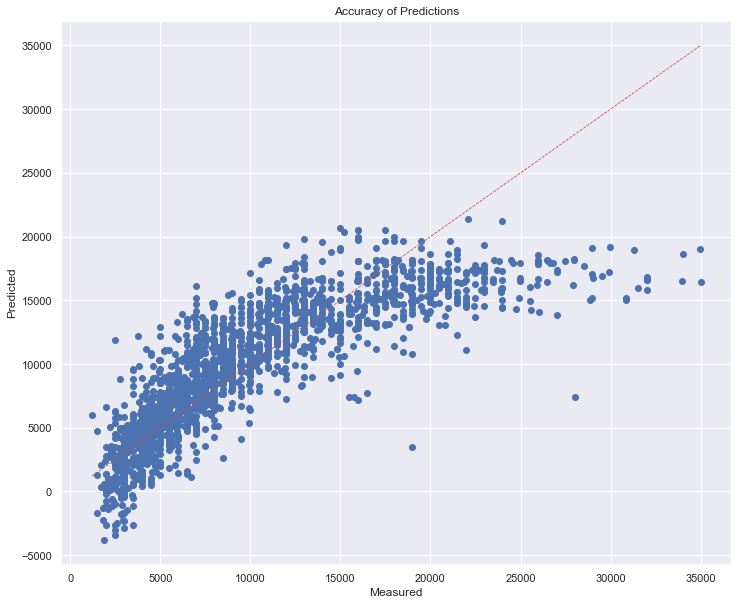

In [325]:
def plot_predictions(y_test,pred):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test,pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
    ax.set_xlabel('Measured');
    ax.set_ylabel('Predicted');
    ax.set_title('Accuracy of Predictions');
    #ax.set_ylim(0,y_test.max());
    
plot_predictions(sport_df['Price'],sport_df['Predicted_Price'])

In [326]:
sport_df['Price_ratio'] = sport_df['Price'] / sport_df['Predicted_Price']

sport_df['Deal_type'] = 'Dont Bother'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.1] = 'Negotiate'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.2] = 'Good Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.5] = 'Great Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 2] = 'Its a steel'




In [328]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.ylim(0,40000)


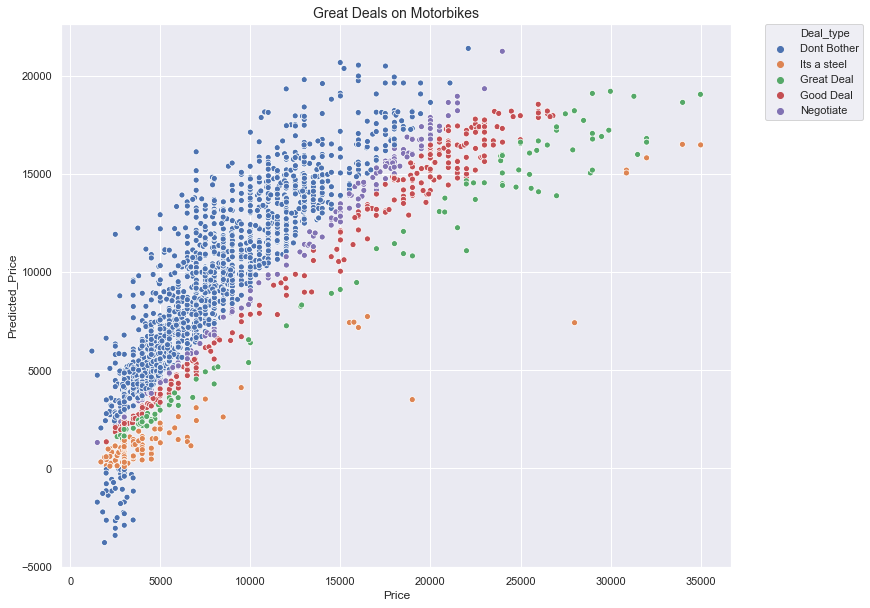

In [329]:
scatter(sport_df,'Price','Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [228]:
outliers = sport_df[(sport_df['Predicted_Price'] > 40000) | (sport_df['Predicted_Price'] < 0)]


In [229]:
outliers[]

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Model_f4 312 r 1000 11,Model_f4 750 s,Model_f4 750 s f4s 11,Model_f4 r,Model_f4 rr,Model_f4 rr 1000,Model_f4ago 1000,Predicted_Price,Price_ratio,Deal_type
9,57.0,1.0,10.000000,1.0,123.0,150.0,290.43605,158.312257,3.459387,12.0,...,0,0,0,0,0,0,0,-6.160000e+02,-3.246753e+00,Dont Bother
176,81.5,1.0,11.000000,2.0,200.0,650.0,300.00000,158.312257,3.459387,17.0,...,0,0,0,0,0,0,0,2.496419e+18,1.522181e-15,Dont Bother
351,97.0,1.0,11.000000,2.0,275.0,1000.0,320.00000,120.000000,4.000000,20.0,...,0,0,0,0,0,0,0,7.987703e+17,6.258370e-15,Dont Bother
421,97.0,1.0,11.000000,2.0,275.0,1000.0,320.00000,120.000000,4.000000,20.0,...,0,0,0,0,0,0,0,7.987703e+17,6.885584e-15,Dont Bother
563,53.5,2.0,10.463877,2.0,129.0,250.0,290.43605,158.312257,3.459387,15.0,...,0,0,0,0,0,0,0,2.017931e+17,3.434210e-14,Dont Bother
